# MMDETECTION-训练

liangyu 20230607

In [5]:
import torch
print(torch.__version__)
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

1.10.1+cu113


In [49]:
!nvcc -V

/bin/bash: line 1: nvcc: command not found


In [50]:
!gcc --version

gcc (Ubuntu 12.2.0-3ubuntu1) 12.2.0
Copyright (C) 2022 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [51]:
import os
path0 = '/home/liangyu/code/mmlab2/2023AI/0608/'
os.chdir(path0)
!pwd

/home/liangyu/code/mmlab2/2023AI/0608


In [52]:
# # Install mmdetection
# !rm -rf mmdetection
# #为了防止后续更新导致的可能无法运行，特意新建了tutorials分支
# !git clone -b tutorials https://kgithub.com/open-mmlab/mmdetection.git
# %cd mmdetection
# %pip install -e .

In [53]:
from mmengine.utils import get_git_hash
from mmengine.utils.dl_utils import collect_env as collect_base_env
import mmdet
#环境信息收集和打印
def collect_env():
    """Collect the information of the running environments."""
    env_info = collect_base_env()
    env_info['MMDetection'] = f'{mmdet.__version__}+{get_git_hash()[:7]}'
    return env_info
if __name__ =='__main__':
    for name, val in collect_env().items():
        print(f'{name}:{val}')

sys.platform:linux
Python:3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) [GCC 11.3.0]
CUDA available:False
numpy_random_seed:410650550
GCC:gcc (Ubuntu 12.2.0-3ubuntu1) 12.2.0
PyTorch:1.10.1+cu113
PyTorch compiling details:PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.3, CUDNN_VERSION=8.2.0, CXX_COMPILER=/opt/rh/devtoolset-7/root/usr/bin/c++, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -fopenmp -DNDEBUG -DUSE_KINETO -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -DUSE_XNNPACK -DSYMBOLICATE_MOBILE_DEBUG_HANDLE -DEDGE_PROFILER_USE_

In [54]:
os.chdir(path0)

In [55]:
pwd

'/home/liangyu/code/mmlab2/2023AI/0608'

In [56]:
# #数据集下载
# !rm -rf cat_dataset*
# !wget https://download.openmmlab.com/mmyolo/data/cat_dataset.zip
# !unzip cat_dataset.zip -d cat dataset &rm cat_dataset.zip

In [57]:
pwd

'/home/liangyu/code/mmlab2/2023AI/0608'

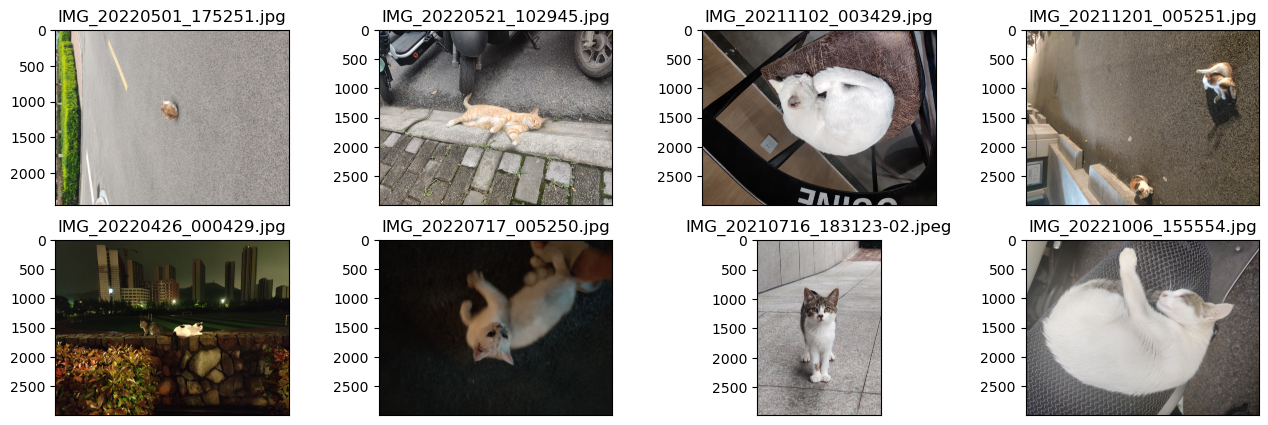

In [58]:
import os
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
#%config InlineBackend.figure format 'retina'
original_images = []
images = []
texts = []
plt.figure(figsize=(16,5))
image_paths=[filename for filename in os.listdir('cat_dataset/images')][:8]
for i,filename in enumerate(image_paths):
    name = os.path.splitext(filename)[0]
    image = Image.open('cat_dataset/images/'+filename).convert("RGB")
    plt.subplot(2,4,i+1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    #plt.tightlayout()

In [60]:
pwd

'/home/liangyu/code/mmlab2/2023AI/0608'

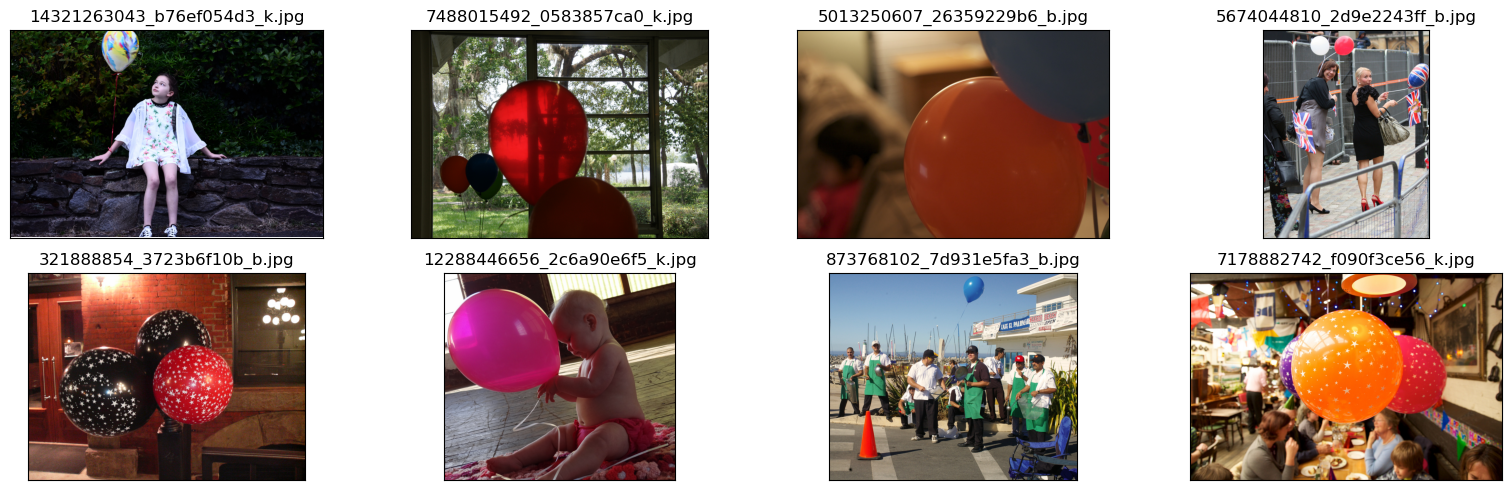

In [64]:
# 1st， 数据集可视化
import os
import matplotlib.pyplot as plt
from PIL import Image

original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

image_paths = [filename for filename in os.listdir('./mmdetection/data/balloon/train')][:8]

for i, filename in enumerate(image_paths):
    name = os.path.splitext(filename)[0]

    image = Image.open('./mmdetection/data/balloon/train/' + filename).convert("RGB")

    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

In [72]:
#2nd 数据格式变为COCO

import os.path as osp
import mmcv
from mmengine.fileio import dump, load
from mmengine.utils import track_iter_progress

def convert_balloon_to_coco(ann_file, out_file, image_prefix):
    data_infos = load(ann_file)

    annotations = []
    images = []
    obj_count = 0
    for idx, v in enumerate(track_iter_progress(data_infos.values())):
        filename = v['filename']
        img_path = osp.join(image_prefix, filename)
        height, width = mmcv.imread(img_path).shape[:2]

        images.append(
            dict(id=idx, file_name=filename, height=height, width=width))

        for _, obj in v['regions'].items():
            assert not obj['region_attributes']
            obj = obj['shape_attributes']
            px = obj['all_points_x']
            py = obj['all_points_y']
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            x_min, y_min, x_max, y_max = (min(px), min(py), max(px), max(py))

            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=0,
                bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                area=(x_max - x_min) * (y_max - y_min),
                segmentation=[poly],
                iscrowd=0)
            annotations.append(data_anno)
            obj_count += 1

    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=[{
            'id': 0,
            'name': 'balloon'
        }])
    dump(coco_format_json, out_file)


if __name__ == '__main__':
    convert_balloon_to_coco(ann_file='./mmdetection/data/balloon/train/via_region_data.json',
                            out_file='./mmdetection/data/balloon/train/annotation_coco.json',
                            image_prefix='./mmdetection/data/balloon/train')

    convert_balloon_to_coco(ann_file='./mmdetection/data/balloon/val/via_region_data.json',
                            out_file='./mmdetection/data/balloon/val/annotation_coco.json',
                            image_prefix='./mmdetection/data/balloon/val')


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 61/61, 50.6 task/s, elapsed: 1s, ETA:     0s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 13/13, 48.0 task/s, elapsed: 0s, ETA:     0s


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


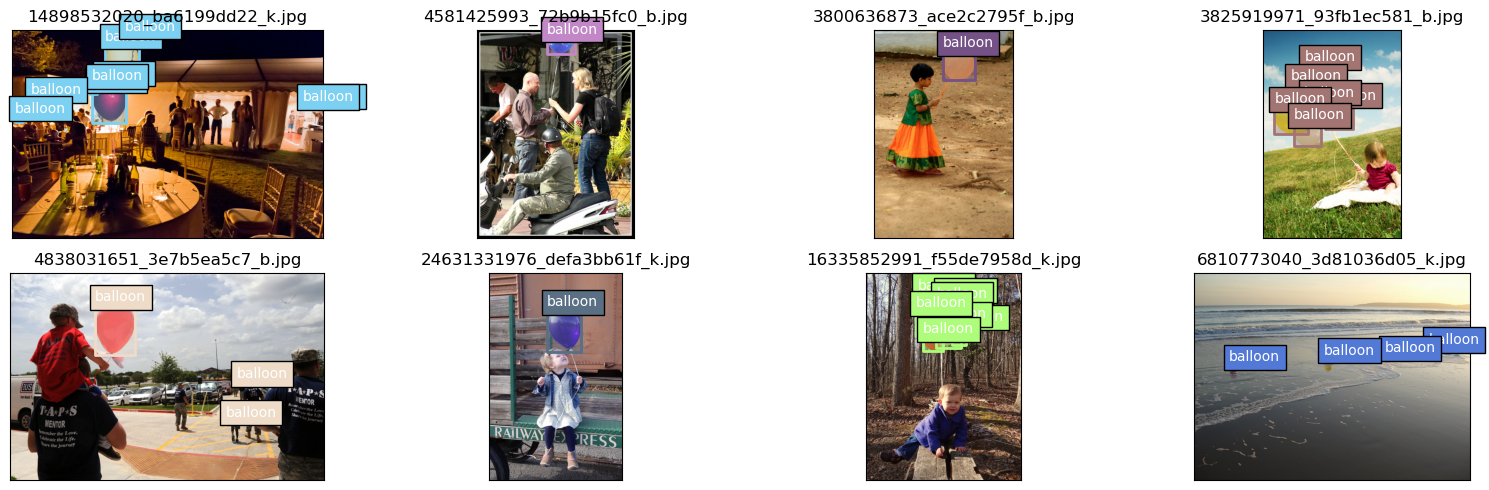

In [73]:
# 3nd show the COCO data
from pycocotools.coco import COCO
import numpy as np
import os.path as osp
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from PIL import Image

def apply_exif_orientation(image):
    _EXIF_ORIENT = 274
    if not hasattr(image, 'getexif'):
        return image

    try:
        exif = image.getexif()
    except Exception:
        exif = None

    if exif is None:
        return image

    orientation = exif.get(_EXIF_ORIENT)

    method = {
        2: Image.FLIP_LEFT_RIGHT,
        3: Image.ROTATE_180,
        4: Image.FLIP_TOP_BOTTOM,
        5: Image.TRANSPOSE,
        6: Image.ROTATE_270,
        7: Image.TRANSVERSE,
        8: Image.ROTATE_90,
    }.get(orientation)
    if method is not None:
        return image.transpose(method)
    return image


def show_bbox_only(coco, anns, show_label_bbox=True, is_filling=True):
    """Show bounding box of annotations Only."""
    if len(anns) == 0:
        return

    ax = plt.gca()
    ax.set_autoscale_on(False)

    image2color = dict()
    for cat in coco.getCatIds():
        image2color[cat] = (np.random.random((1, 3)) * 0.7 + 0.3).tolist()[0]

    polygons = []
    colors = []

    for ann in anns:
        color = image2color[ann['category_id']]
        bbox_x, bbox_y, bbox_w, bbox_h = ann['bbox']
        poly = [[bbox_x, bbox_y], [bbox_x, bbox_y + bbox_h],
                [bbox_x + bbox_w, bbox_y + bbox_h], [bbox_x + bbox_w, bbox_y]]
        polygons.append(Polygon(np.array(poly).reshape((4, 2))))
        colors.append(color)

        if show_label_bbox:
            label_bbox = dict(facecolor=color)
        else:
            label_bbox = None

        ax.text(
            bbox_x,
            bbox_y,
            '%s' % (coco.loadCats(ann['category_id'])[0]['name']),
            color='white',
            bbox=label_bbox)

    if is_filling:
        p = PatchCollection(
            polygons, facecolor=colors, linewidths=0, alpha=0.4)
        ax.add_collection(p)
    p = PatchCollection(
        polygons, facecolor='none', edgecolors=colors, linewidths=2)
    ax.add_collection(p)


coco = COCO('./mmdetection/data/balloon/val/annotation_coco.json')
image_ids = coco.getImgIds()
print(image_ids)
np.random.shuffle(image_ids)

plt.figure(figsize=(16, 5))

# 只可视化 8 张图片
for i in range(8):
    image_data = coco.loadImgs(image_ids[i])[0]
    image_path = osp.join('./mmdetection/data/balloon/val/', image_data['file_name'])
    annotation_ids = coco.getAnnIds(
        imgIds=image_data['id'], catIds=[], iscrowd=0)
    annotations = coco.loadAnns(annotation_ids)

    ax = plt.subplot(2, 4, i + 1)
    image = Image.open(image_path).convert("RGB")

    # 这行代码很关键，否则可能图片和标签对不上
    image = apply_exif_orientation(image)

    ax.imshow(image)

    show_bbox_only(coco, annotations)

    plt.title(f"{image_data['file_name']}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/home/liangyu/miniconda3/envs/mmlab2/lib/python3.9/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(
/home/liangyu/miniconda3/envs/mmlab2/lib/python3.9/site-packages/mmengine/visualization/visualizer.py:757: UserWarning: Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  warnings.warn(
/home/liangyu/miniconda3/envs/mmlab2/lib/python3.9/site-packages/mmengine/visualization/visualizer.py:828: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(


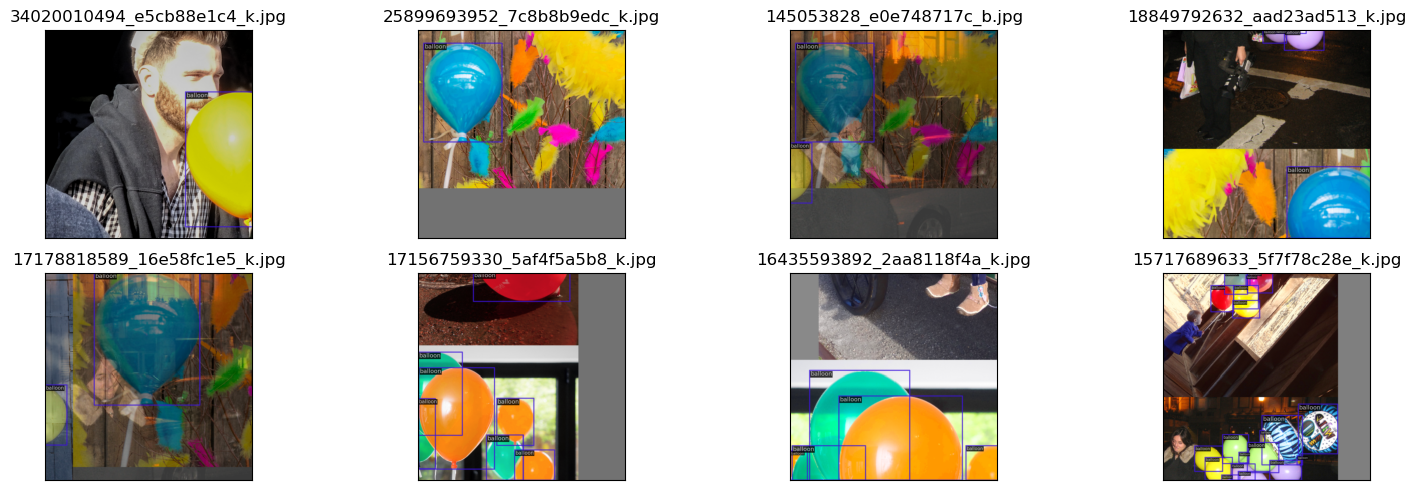

In [76]:
#4 训练前可视化
from mmdet.registry import DATASETS, VISUALIZERS
from mmengine.config import Config
from mmengine.registry import init_default_scope
import matplotlib.pyplot as plt
import os.path as osp
cfg = Config.fromfile('./mmdetection/configs/rtmdet/rtmdet_tiny_1xb4-20e_balloon.py')

init_default_scope(cfg.get('default_scope', 'mmdet'))
dataset = DATASETS.build(cfg.train_dataloader.dataset)
visualizer = VISUALIZERS.build(cfg.visualizer)
visualizer.dataset_meta = dataset.metainfo

plt.figure(figsize=(16, 5))

# 只可视化前 8 张图片
for i in range(8):
   item=dataset[i]

   img = item['inputs'].permute(1, 2, 0).numpy()
   data_sample = item['data_samples'].numpy()
   gt_instances = data_sample.gt_instances
   img_path = osp.basename(item['data_samples'].img_path)

   gt_bboxes = gt_instances.get('bboxes', None)
   gt_instances.bboxes = gt_bboxes.tensor
   data_sample.gt_instances = gt_instances

   visualizer.add_datasample(
            osp.basename(img_path),
            img,
            data_sample,
            draw_pred=False,
            show=False)
   drawed_image=visualizer.get_image()

   plt.subplot(2, 4, i+1)
   plt.imshow(drawed_image[..., [2, 1, 0]])
   plt.title(f"{osp.basename(img_path)}")
   plt.xticks([])
   plt.yticks([])

plt.tight_layout()
plt.show()


In [80]:
os.chdir(path0)

In [81]:
pwd

'/home/liangyu/code/mmlab2/2023AI/0608'

In [ ]:
#!python tools/train.py configs/rtmdet/rtmdet_tiny_1xb4-20e_balloon.py --work-dir ./projects/fruits/exp

In [91]:
!python ./mmdetection/tools/train.py ./mmdetection/configs/rtmdet/rtmdet_tiny_1xb4-20e_balloon.py

06/12 22:46:51 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) [GCC 11.3.0]
    CUDA available: False
    numpy_random_seed: 1701711356
    GCC: gcc (Ubuntu 12.2.0-3ubuntu1) 12.2.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.3, CUDNN_VERSION=8.2.0, CXX_COMPILER=/opt/rh/devtoolset-7/root/usr/bin/c++, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -DUSE_PTHREAD

# 测试结果

In [93]:
pwd

'/home/liangyu/code/mmlab2/2023AI/0608'

In [95]:
!python ./mmdetection/tools/test.py ./mmdetection/configs/rtmdet/rtmdet_tiny_1xb4-20e_balloon.py \
    ./work_dirs/rtmdet_tiny_1xb4-20e_balloon/best_coco_bbox_mAP_epoch_40.pth

06/12 22:54:36 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) [GCC 11.3.0]
    CUDA available: False
    numpy_random_seed: 1473989296
    GCC: gcc (Ubuntu 12.2.0-3ubuntu1) 12.2.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.3, CUDNN_VERSION=8.2.0, CXX_COMPILER=/opt/rh/devtoolset-7/root/usr/bin/c++, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -DUSE_PTHREAD

# 测试单张, 放弃！！！ demo.py
# 没有 cuda 环境，仅用CPU会报错

In [7]:
!python ./mmdetection/demo/image_demo.py ./mmdetection/data/balloon/test/test1.png \
    ./mmdetection/configs/rtmdet/rtmdet_tiny_1xb4-20e_balloon.py \
        --weights ./work_dirs/rtmdet_tiny_1xb4-20e_balloon/best_coco_bbox_mAP_epoch_40.pth

Loads checkpoint by local backend from path: ./work_dirs/rtmdet_tiny_1xb4-20e_balloon/best_coco_bbox_mAP_epoch_40.pth
Traceback (most recent call last):
  File "/home/liangyu/code/mmlab2/2023AI/0608/./mmdetection/demo/image_demo.py", line 119, in <module>
    main()
  File "/home/liangyu/code/mmlab2/2023AI/0608/./mmdetection/demo/image_demo.py", line 109, in main
    inferencer = DetInferencer(**init_args)
  File "/home/liangyu/miniconda3/envs/mmlab2/lib/python3.9/site-packages/mmdet/apis/det_inferencer.py", line 95, in __init__
    super().__init__(
  File "/home/liangyu/miniconda3/envs/mmlab2/lib/python3.9/site-packages/mmengine/infer/infer.py", line 176, in __init__
    self.model = self._init_model(cfg, weights, device)  # type: ignore
  File "/home/liangyu/miniconda3/envs/mmlab2/lib/python3.9/site-packages/mmengine/infer/infer.py", line 480, in _init_model
    model.to(device)
  File "/home/liangyu/miniconda3/envs/mmlab2/lib/python3.9/site-packages/mmengine/model/base_model/base_m

# 可视化

In [11]:
!rm mmyolo -rf
!git clone -b tutorials https://ghproxy.com/https://github.com/open-mmlab/mmyolo.git 


Cloning into 'mmyolo'...
remote: Enumerating objects: 4911, done.
remote: Counting objects: 100% (302/302), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 4911 (delta 131), reused 234 (delta 114), pack-reused 4609
Receiving objects: 100% (4911/4911), 3.77 MiB | 3.58 MiB/s, done.
Resolving deltas: 100% (3015/3015), done.


In [12]:
!mim install -e ./mmyolo -i https://pypi.tuna.tsinghua.edu.cn/simple/

/home/liangyu/miniconda3/envs/mmlab2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.10.0/index.html
Obtaining file:///home/liangyu/code/mmlab2/2023AI/0608/mmyolo
  Preparing metadata (setup.py) ... done
/home/liangyu/miniconda3/envs/mmlab2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
  Running setup.py develop for mmyolo


In [13]:
!mim install mmyolo -i https://pypi.tuna.tsinghua.edu.cn/simple/

/home/liangyu/miniconda3/envs/mmlab2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.10.0/index.html
/home/liangyu/miniconda3/envs/mmlab2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(


In [4]:
from PIL import Image
import numpy as np
import matplotlib as plt
img = Image.open('/home/liangyu/code/mmlab2/2023AI/0608/mmdetection/data/balloon/test/test1.png')
img = np.array(img)
img.shape

(1024, 701, 3)

# 同样的问题，因为硬件不支持cuda, 放弃
# demo 中的使用代码都不能兼容硬件，放弃该步骤。

In [15]:
import os
os.chdir('mmyolo')

In [20]:
!python demo/featmap_vis_demo.py \
      /home/liangyu/code/mmlab2/2023AI/0608/mmdetection/balloon/test/test1.png \
      /home/liangyu/code/mmlab2/2023AI/0608/mmdetection/configs/rtmdet/rtmdet_tiny_1xb4-20e_balloon.py \
      /home/liangyu/code/mmlab2/2023AI/0608/work_dirs/rtmdet_tiny_1xb4-20e_balloon/best_coco_bbox_mAP_epoch_40.pth \
      --target-layers backbone  \
      --channel-reduction squeeze_mean

Loads checkpoint by local backend from path: /home/liangyu/code/mmlab2/2023AI/0608/work_dirs/rtmdet_tiny_1xb4-20e_balloon/best_coco_bbox_mAP_epoch_40.pth
Traceback (most recent call last):
  File "/home/liangyu/code/mmlab2/2023AI/0608/mmyolo/demo/featmap_vis_demo.py", line 199, in <module>
    main()
  File "/home/liangyu/code/mmlab2/2023AI/0608/mmyolo/demo/featmap_vis_demo.py", line 110, in main
    model = init_detector(args.config, args.checkpoint, device=args.device)
  File "/home/liangyu/miniconda3/envs/mmlab2/lib/python3.9/site-packages/mmdet/apis/inference.py", line 109, in init_detector
    model.to(device)
  File "/home/liangyu/miniconda3/envs/mmlab2/lib/python3.9/site-packages/mmengine/model/base_model/base_model.py", line 202, in to
    return super().to(*args, **kwargs)
  File "/home/liangyu/miniconda3/envs/mmlab2/lib/python3.9/site-packages/torch/nn/modules/module.py", line 899, in to
    return self._apply(convert)
  File "/home/liangyu/miniconda3/envs/mmlab2/lib/python3.

In [ ]:
# done!